In [ ]:
!pip install google-cloud-aiplatform google-cloud-storage
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Flatten, Attention, Input
from tensorflow.keras.layers import TimeDistributed
import pandas as pd
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os
from datetime import datetime
import gc
import psutil

In [ ]:
from google.cloud import storage

BUCKET_NAME = "gold_predictions_web"  # เปลี่ยนเป็นชื่อ Bucket ของคุณ

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)
print(f"เชื่อมต่อกับ GCS Bucket: {BUCKET_NAME}")

เชื่อมต่อกับ GCS Bucket: gold_predictions_web


In [ ]:
import requests
nowDate=datetime.now()
startTime=f'{nowDate.year-10}-{nowDate.month}-{nowDate.day}'
endTime=f'{nowDate.year}-{nowDate.month}-{nowDate.day}'
startTime_1=f'{nowDate.day}-{nowDate.month}-{nowDate.year-10}'
endTime_1=f'{nowDate.day}-{nowDate.month}-{nowDate.year}'
url_currency = f"https://gold-predictions.duckdns.org/currency/get/?start={startTime}&end={endTime}&cache=False"
url_Gold_usd = f"https://gold-predictions.duckdns.org/finnomenaGold/get-gold-data/?db_choice=1&start={startTime_1}&end={endTime_1}&cache=False"
url_Gold_thb = f"https://gold-predictions.duckdns.org/finnomenaGold/get-gold-data/?db_choice=0&start={startTime_1}&end={endTime_1}&cache=False"
# เรียก API และดึงข้อมูล
response = requests.get(url_currency)

# ตรวจสอบว่าการเรียก API สำเร็จหรือไม่
if response.status_code == 200:
    data_currency = response.json()  # แปลงข้อมูลเป็น JSON
    data_list = data_currency["data"]
    df_currency = pd.DataFrame(data_list)  # สร้าง DataFrame
    print(df_currency.tail())  # แสดงตัวอย่างข้อมูล
else:
    print(f"Error: {response.status_code}")

response = requests.get(url_Gold_usd)

# ตรวจสอบว่าการเรียก API สำเร็จหรือไม่
if response.status_code == 200:
    data_Gold_usd = response.json()  # แปลงข้อมูลเป็น JSON
    data_list = data_Gold_usd["data"]
    df_Gold_usd = pd.DataFrame(data_list)  # สร้าง DataFrame
    print(df_Gold_usd.tail())  # แสดงตัวอย่างข้อมูล
else:
    print(f"Error: {response.status_code}")

response = requests.get(url_Gold_thb)

# ตรวจสอบว่าการเรียก API สำเร็จหรือไม่
if response.status_code == 200:
    data_Gold_thb = response.json()  # แปลงข้อมูลเป็น JSON
    data_list = data_Gold_thb["data"]
    df_Gold_thb = pd.DataFrame(data_list)  # สร้าง DataFrame
    print(df_Gold_thb.tail())  # แสดงตัวอย่างข้อมูล
else:
    print(f"Error: {response.status_code}")

df_currency=df_currency[['date','price']]
df_currency.columns = ['Date', 'price_exchange']

df_Gold_thb=df_Gold_thb[['timestamp','price']]
df_Gold_thb = df_Gold_thb.copy()
df_Gold_thb['timestamp'] = df_Gold_thb['timestamp'].apply(lambda x: x // 1000 if x > 10**12 else x)
df_Gold_thb['timestamp'] = pd.to_datetime(df_Gold_thb['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
df_Gold_thb['timestamp'] = df_Gold_thb['timestamp'].dt.strftime('%d/%m/%Y')
df_Gold_thb.columns = ['Date', 'Thai_Gold']

df_Gold_usd=df_Gold_usd[['timestamp','close_price']]
df_Gold_usd = df_Gold_usd.copy()
df_Gold_usd['timestamp'] = df_Gold_usd['timestamp'].apply(lambda x: x // 1000 if x > 10**12 else x)
df_Gold_usd['timestamp'] = pd.to_datetime(df_Gold_usd['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
df_Gold_usd['timestamp'] = df_Gold_usd['timestamp'].dt.strftime('%d/%m/%Y')
df_Gold_usd.columns = ['Date', 'Xau']


# รวม DataFrame ทั้งสามโดยใช้ date เป็นคีย์อ้างอิง
df_currency['Date'] = pd.to_datetime(df_currency['Date'], format='%Y-%m-%d').dt.normalize()
df_Gold_thb['Date'] = pd.to_datetime(df_Gold_thb['Date'], format='%d/%m/%Y').dt.normalize()
df_Gold_usd['Date'] = pd.to_datetime(df_Gold_usd['Date'], format='%d/%m/%Y').dt.normalize()
merged_df = (
    df_Gold_thb
    .merge(df_Gold_usd, on='Date', how='outer')
    .merge(df_currency, on='Date', how='outer')
)
merged_df = (
    merged_df
    .sort_values('Date')
    .groupby('Date', as_index=False)
    .first()  # เอาแถวแรกของแต่ละวัน
)
print(df_currency.dtypes)
print(df_Gold_thb.dtypes)
print(df_Gold_usd.dtypes)

merged_df[['Xau']] = merged_df[['Xau']].shift(1)
merged_df['Xau'] = merged_df['Xau'].ffill()
merged_df.dropna(inplace=True)
merged_df.to_csv('acvs.csv')
dupes = merged_df[merged_df.duplicated('Date', keep=False)]
print(f"จำนวนวันที่ซ้ำ: {len(dupes)}")
print(dupes.sort_values('Date'))

          id        date   price   open    high     low  percent   diff
6881  187909  2025-04-11  33.508  33.82  33.857  33.450  -0.9577 -0.324
6882  194908  2025-04-14  33.530  33.51  33.735  33.415   0.0000  0.000
6883  194909  2025-04-15  33.540  33.63  33.640  33.435   0.0298  0.010
6884  194910  2025-04-16  33.087  33.08  33.595  33.035  -1.3506 -0.453
6885  194911  2025-04-17  33.293  33.08  33.375  33.078   0.6226  0.206
         id      timestamp    price  close_price  high_price  low_price  \
3044  78476  1744502400000  3238.07      3223.90     3238.07    3210.60   
3045  78477  1744588800000  3221.80      3212.34     3245.23    3194.59   
3046  78478  1744675200000  3212.71      3250.51     3250.80    3210.20   
3047  78479  1744761600000  3252.86      3349.52     3357.01    3250.34   
3048  78480  1744848000000  3349.87      3323.50     3355.33    3312.96   

      volume  volume_weight_avg  num_transactions      date  \
3044   262.0          3219.8965               262  13-

<ipython-input-7-02d4f766f518>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_currency['Date'] = pd.to_datetime(df_currency['Date'], format='%Y-%m-%d').dt.normalize()


📂 พบโฟลเดอร์ models, กำลังย้ายไฟล์ไปที่ models_old...
✅ ย้าย models/Future_1.keras -> models_old/Future_1.keras
🗑️ ลบไฟล์เก่า models/Future_1.keras
✅ ย้าย models/Future_2.keras -> models_old/Future_2.keras
🗑️ ลบไฟล์เก่า models/Future_2.keras
✅ ย้าย models/Future_3.keras -> models_old/Future_3.keras
🗑️ ลบไฟล์เก่า models/Future_3.keras
✅ ย้าย models/Future_4.keras -> models_old/Future_4.keras
🗑️ ลบไฟล์เก่า models/Future_4.keras
✅ ย้าย models/Future_5.keras -> models_old/Future_5.keras
🗑️ ลบไฟล์เก่า models/Future_5.keras
✅ ย้าย models/Future_6.keras -> models_old/Future_6.keras
🗑️ ลบไฟล์เก่า models/Future_6.keras
✅ ย้าย models/Future_7.keras -> models_old/Future_7.keras
🗑️ ลบไฟล์เก่า models/Future_7.keras
✅ ย้าย models/History_Model_1.png -> models_old/History_Model_1.png
🗑️ ลบไฟล์เก่า models/History_Model_1.png
✅ ย้าย models/History_Model_2.png -> models_old/History_Model_2.png
🗑️ ลบไฟล์เก่า models/History_Model_2.png
✅ ย้าย models/History_Model_3.png -> models_old/History_Model_3.png
🗑️

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0180 - val_loss: 9.2652e-04 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 1.8306e-04 - learning_rate: 0.0010
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4962e-04 - val_loss: 1.8355e-04 - learning_rate: 0.0010
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6133e-04 - val_loss: 1.6170e-04 - learning_rate: 0.0010
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0983e-04 - val_loss: 2.1126e-04 - learning_rate: 0.0010
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0979e-04 - val_loss: 1.7436e-04 - learning_rate: 0.0010
Epoch 7/100
70/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7868e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7358e-04 - val_loss: 4.0439e-04 - learning_rate: 0.0010
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3162e-

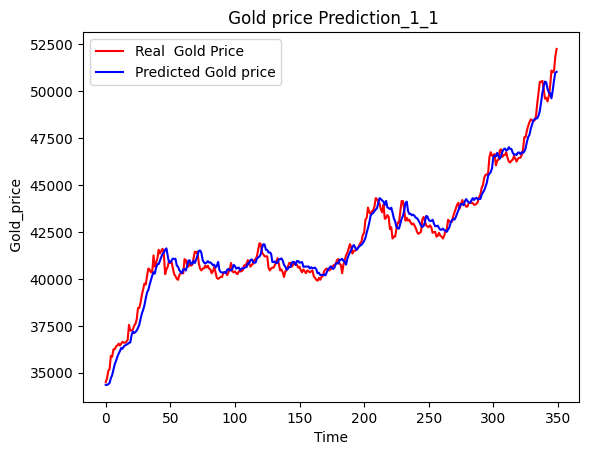

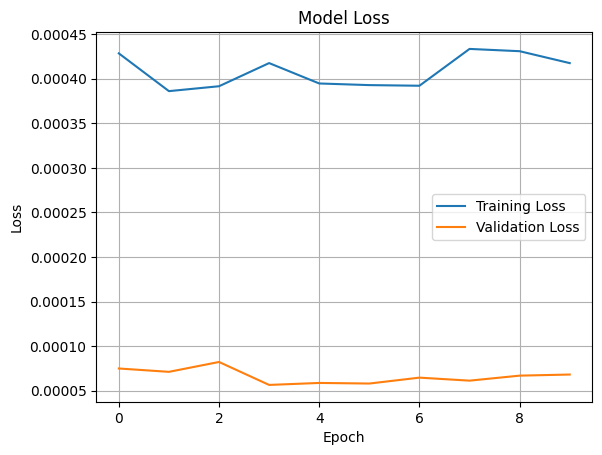

Future = 1
lag=1
X_train shape: (2372, 1, 5), y_train shape: (2372, 1)
X_val shape: (350, 1, 5), y_val shape: (350, 1)
X_test shape: (350, 1, 5), y_test shape: (350, 1)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0189 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 1.1558e-04 - learning_rate: 0.0010
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9885e-04 - val_loss: 1.5636e-04 - learning_rate: 0.0010
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7345e-04 - val_loss: 1.8294e-04 - learning_rate: 0.0010
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1423e-04 - val_loss: 1.2192e-04 - learning_rate: 0.0010
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1370e-04 - val_loss: 1.9286e-04 - learning_rate: 0.0010
Epoch 7/100
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8063e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7002e-04 - val_loss: 9.9009e-05 - learning_rate: 0.0010
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4687e-04 -

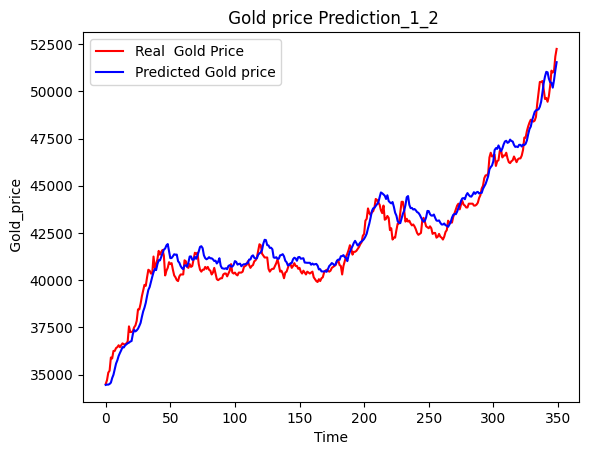

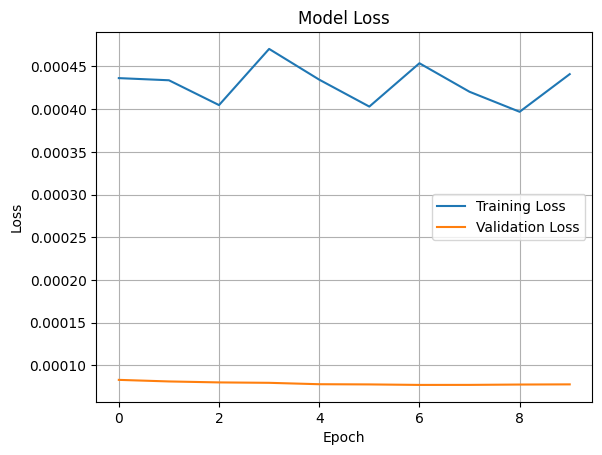

Future = 2
lag=1
X_train shape: (2371, 1, 4), y_train shape: (2371, 1)
X_val shape: (350, 1, 4), y_val shape: (350, 1)
X_test shape: (350, 1, 4), y_test shape: (350, 1)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0176 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 1.6382e-04 - learning_rate: 0.0010
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8639e-04 - val_loss: 1.2307e-04 - learning_rate: 0.0010
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6293e-04 - val_loss: 1.1708e-04 - learning_rate: 0.0010
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0458e-04 - val_loss: 2.8433e-04 - learning_rate: 0.0010
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5776e-04 - val_loss: 1.0889e-04 - learning_rate: 0.0010
Epoch 7/100
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7171e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7325e-04 - val_loss: 1.2637e-04 - learning_rate: 0.0010
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3315e-04 -

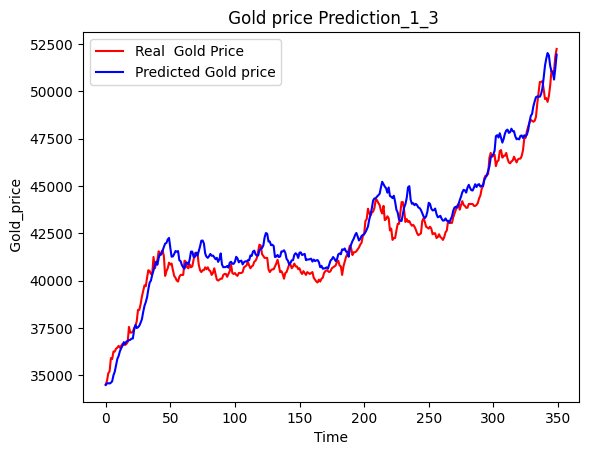

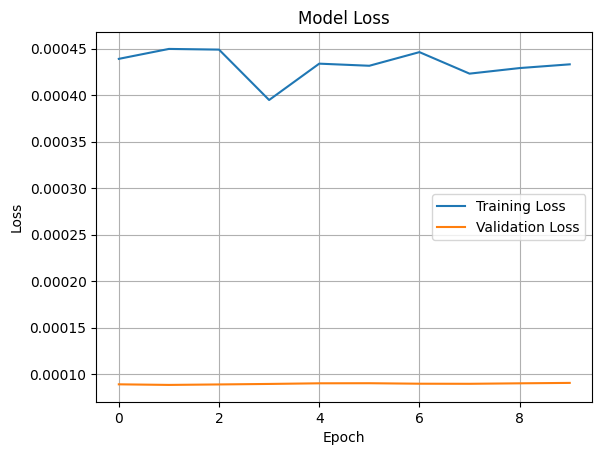

Future = 3
lag=1
X_train shape: (2370, 1, 4), y_train shape: (2370, 1)
X_val shape: (350, 1, 4), y_val shape: (350, 1)
X_test shape: (350, 1, 4), y_test shape: (350, 1)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0189 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 1.4858e-04 - learning_rate: 0.0010
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0978e-04 - val_loss: 1.4860e-04 - learning_rate: 0.0010
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8520e-04 - val_loss: 4.1506e-04 - learning_rate: 0.0010
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0891e-04 - val_loss: 1.3526e-04 - learning_rate: 0.0010
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4181e-04 - val_loss: 1.2388e-04 - learning_rate: 0.0010
Epoch 7/100
69/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2879e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2668e-04 - val_loss: 1.4234e-04 - learning_rate: 0.0010
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1630e-04 

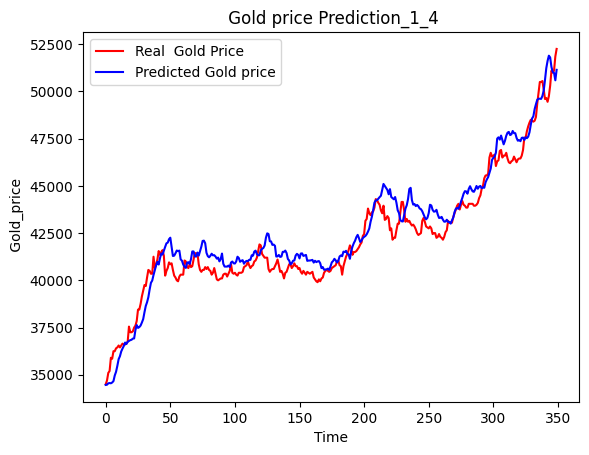

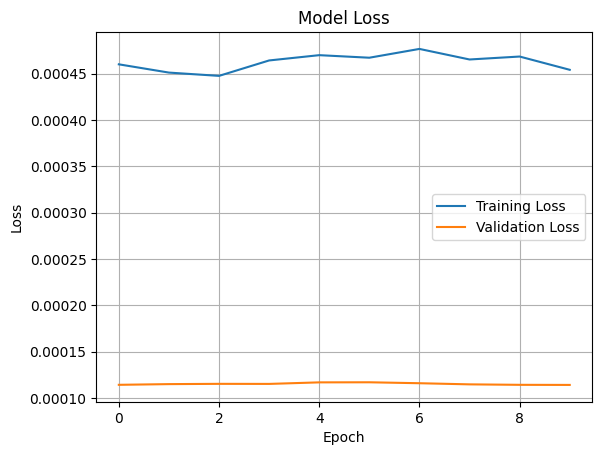

Future = 4
lag=1
X_train shape: (2369, 1, 4), y_train shape: (2369, 1)
X_val shape: (350, 1, 4), y_val shape: (350, 1)
X_test shape: (350, 1, 4), y_test shape: (350, 1)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0194 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 1.9096e-04 - learning_rate: 0.0010
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8421e-04 - val_loss: 1.8202e-04 - learning_rate: 0.0010
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7362e-04 - val_loss: 2.2454e-04 - learning_rate: 0.0010
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7458e-04 - val_loss: 2.2404e-04 - learning_rate: 0.0010
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6331e-04 - val_loss: 1.6058e-04 - learning_rate: 0.0010
Epoch 7/100
68/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4966e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5398e-04 - val_loss: 1.6250e-04 - learning_rate: 0.0010
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3235e-04 

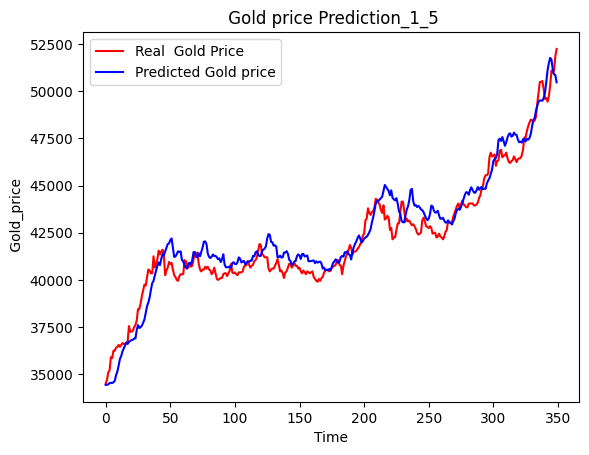

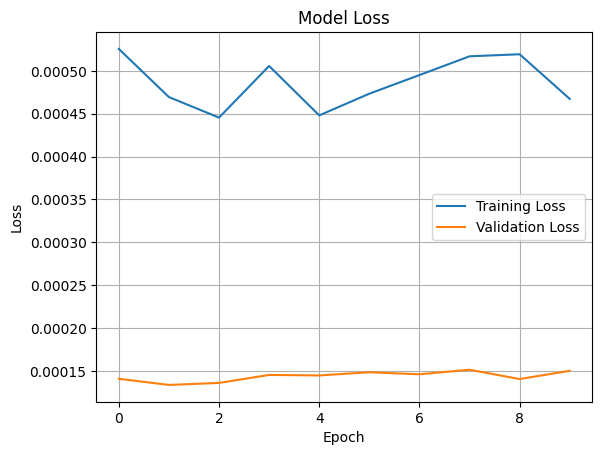

Future = 5
lag=1
X_train shape: (2368, 1, 4), y_train shape: (2368, 1)
X_val shape: (350, 1, 4), y_val shape: (350, 1)
X_test shape: (350, 1, 4), y_test shape: (350, 1)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0186 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 2.0801e-04 - learning_rate: 0.0010
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3115e-04 - val_loss: 1.9963e-04 - learning_rate: 0.0010
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5651e-04 - val_loss: 1.9005e-04 - learning_rate: 0.0010
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8629e-04 - val_loss: 2.0877e-04 - learning_rate: 0.0010
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2908e-04 - val_loss: 1.8230e-04 - learning_rate: 0.0010
Epoch 7/100
70/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2422e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2143e-04 - val_loss: 1.7933e-04 - learning_rate: 0.0010
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2867e-04 -

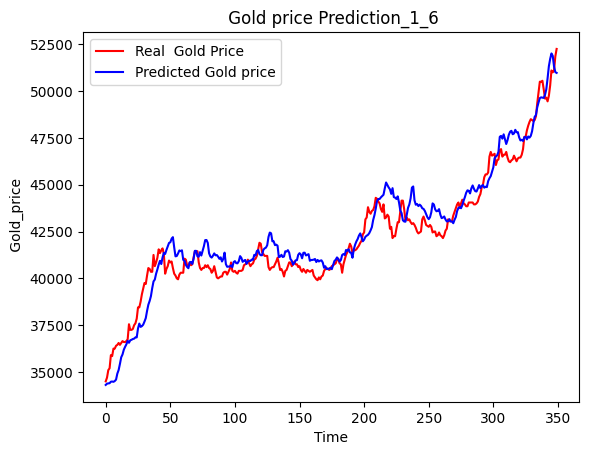

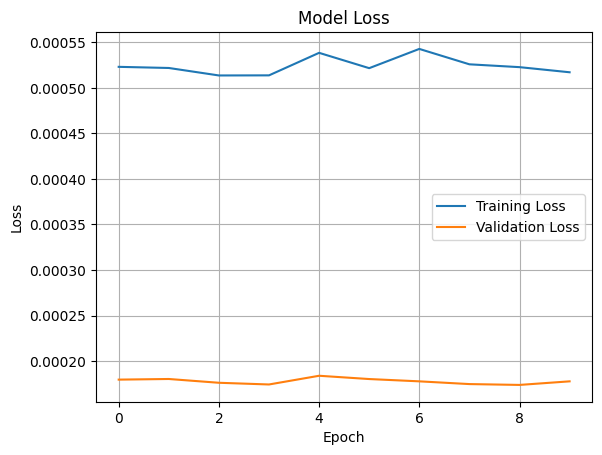

Future = 6
lag=1
X_train shape: (2367, 1, 3), y_train shape: (2367, 1)
X_val shape: (350, 1, 3), y_val shape: (350, 1)
X_test shape: (350, 1, 3), y_test shape: (350, 1)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0227 - val_loss: 0.0243 - learning_rate: 0.0010
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 3.0785e-04 - learning_rate: 0.0010
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8572e-04 - val_loss: 2.2217e-04 - learning_rate: 0.0010
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3523e-04 - val_loss: 3.2431e-04 - learning_rate: 0.0010
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9892e-04 - val_loss: 3.1875e-04 - learning_rate: 0.0010
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1617e-04 - val_loss: 2.1796e-04 - learning_rate: 0.0010
Epoch 7/100
64/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1896e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2255e-04 - val_loss: 2.3474e-04 - learning_rate: 0.0010
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1727e-04 -

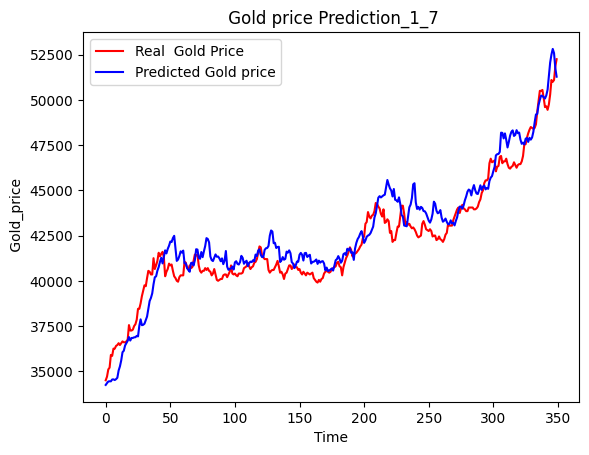

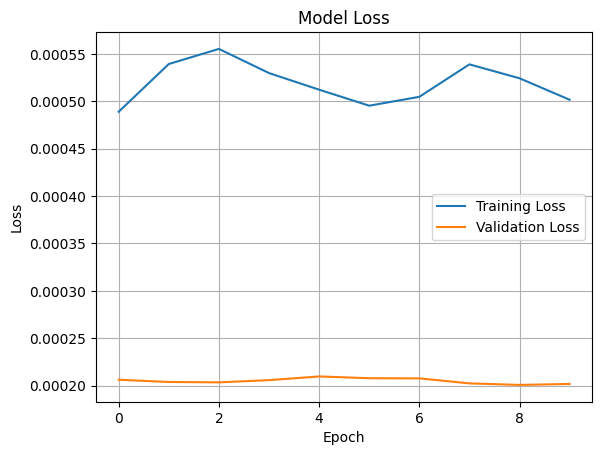

Future = 7


In [ ]:
seq = [1,1,1,1,1,1,1]
fut = [1,2,3,4,5,6,7]
movingavg=[2,2,1,1,1,1,0]
lag=[1,1,1,1,1,1,1]
dateonoff=[False,False,False,False,False,False,False]

BUCKET_NAME = "gold_predictions_web"  # เปลี่ยนเป็นชื่อ bucket ของคุณ
OLD_FOLDER = "models"
NEW_FOLDER = "models_old"


blobs = list(bucket.list_blobs(prefix=f"{OLD_FOLDER}/"))

if blobs:  # ถ้ามีไฟล์ในโฟลเดอร์ "models"
    print(f"📂 พบโฟลเดอร์ {OLD_FOLDER}, กำลังย้ายไฟล์ไปที่ {NEW_FOLDER}...")

    for blob in blobs:
        # ตั้งค่า path ใหม่
        new_blob_name = blob.name.replace(OLD_FOLDER, NEW_FOLDER, 1)

        # คัดลอกไฟล์ไปยังตำแหน่งใหม่
        new_blob = bucket.copy_blob(blob, bucket, new_blob_name)
        print(f"✅ ย้าย {blob.name} -> {new_blob_name}")

        # ลบไฟล์เก่าหลังจากคัดลอกเสร็จ
        blob.delete()
        print(f"🗑️ ลบไฟล์เก่า {blob.name}")

    print(f"🎉 ย้ายไฟล์ทั้งหมดจาก {OLD_FOLDER} -> {NEW_FOLDER} สำเร็จ!")
else:
    print(f"❌ ไม่พบโฟลเดอร์ {OLD_FOLDER} ใน GCS")
# folder_path = os.path.join(base_path, f"folder_{current_time}")
# os.makedirs(folder_path, exist_ok=True)
for indexfut in range(len(fut)):
          data = merged_df.copy()
          data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
          if dateonoff[indexfut] == True:
            data['Day_of_week'] = data['Date'].dt.day_name()
            data['Day'] = data['Date'].dt.day
            data['Month'] = data['Date'].dt.month
            data = pd.get_dummies(data, columns=['Day_of_week'], drop_first=True)

          if movingavg[indexfut] >=4:
            data['MA_20'] = data['Thai_Gold'].ewm(span=20, adjust=True).mean()
          if movingavg[indexfut] >=3:
            data['MA_14'] = data['Thai_Gold'].ewm(span=14, adjust=False).mean()
          if movingavg[indexfut] >=2:
            data['MA_10'] = data['Thai_Gold'].ewm(span=10, adjust=True).mean()
          if movingavg[indexfut] >=1:
            data['MA_7'] = data['Thai_Gold'].ewm(span=7, adjust=False).mean()
          data.dropna(inplace=True)

          target = 'Thai_Gold'
          data_clone=data
          X = data.drop(columns=['Thai_Gold','Date'])
          y = data[target].values
          for i in range(1, lag[indexfut]+1):  # สร้างย้อนหลัง 7 วัน
              print(f'lag={i}')
              X[f'Thai_Gold_Lag_{i}'] = data_clone['Thai_Gold'].shift(i)
          X = X.dropna().reset_index(drop=True)
          y=y.reshape(-1, 1)
          y = np.array(y, dtype=np.float64)
          y = y[lag[indexfut]:]
          dataframe_y=y
          dataframe_x=X
          X=X.values
          scaler_X = MinMaxScaler(feature_range=(0,1))
          scaler_y = MinMaxScaler(feature_range=(0,1))
          X = scaler_X.fit_transform(X)
          y = scaler_y.fit_transform(y)

          def createXY(DataX,DataY, n_past, future):
              dataX = []
              dataY = []
              for i in range(n_past, len(DataX) - future):
                  dataX.append(DataX[i - n_past:i,:])  # ดึงทุกฟีเจอร์ (ทุกคอลัมน์)
                  dataY.append(DataY[i+future])  # ทำนายเฉพาะคอลัมน์ 0 (หรือหลายคอลัมน์หากต้องการ)
              return np.array(dataX), np.array(dataY)

          lookback = seq[indexfut]  # ดูย้อนหลัง 30 วัน
          n_future = fut[indexfut]
          X_seq, y_seq = createXY(X, y, lookback, n_future)

          # กำหนดขนาดข้อมูล
          test_size = 350     # ขนาด Test Set
          val_size = 350      # ขนาด Validation Set
          train_size = X_seq.shape[0] - (val_size + test_size)  # ขนาด Training Set

          # แบ่งข้อมูลเป็น Training, Validation และ Test ตามลำดับเวลา
          X_train, y_train = X_seq[:train_size], y_seq[:train_size]
          X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
          X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

                    # ตรวจสอบขนาดของชุดข้อมูล
          print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
          print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
          print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


          # สร้างโมเดล LSTM
          model = Sequential()
          model.add(LSTM(75, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
          model.add(Dropout(0.2))
          model.add(LSTM(units=50, return_sequences=False))
          model.add(Dropout(0.4))
          model.add(Dense(1))
          optimizer = Adam()
          model.compile(optimizer=optimizer, loss='mean_squared_error',)

          early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
          reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

          # เก็บค่าชี้วัดของโมเดลทั้งหมด
          metrics_list = []
          predict_list=[]
          ori_list=[]
          # เทรนโมเดล 5 รอบ
          models = []
          histro=[]
          for loopTrain in range(10):
            history = model.fit(
                X_train,
                y_train,
                validation_data=(X_val, y_val),
                epochs=100,
                batch_size=32,
                callbacks=[early_stop, reduce_lr]
            )

            # ทำการทำนาย
            prediction=model.predict(X_test)

            # แปลงผลการทำนายและค่าจริงกลับไปเป็นค่าเดิม (inverse scaling)
            predict_ori=scaler_y.inverse_transform(prediction)
            actual_ori=scaler_y.inverse_transform(y_test)

            # แสดงผล
            # if indexfut == 0:
            #   predict1=predict_ori
            # if indexfut == 1:
            #   predict2=predict_ori
            # if indexfut == 2:
            #   predict3=predict_ori
            # if indexfut == 3:
            #   predict4=predict_ori
            # if indexfut == 4:
            #   predict5=predict_ori
            # if indexfut == 5:
            #   predict6=predict_ori
            # if indexfut == 6:
            #   predict7=predict_ori
            ori_list.append(actual_ori)
            predict_list.append(predict_ori)

            # Calculate MAPE
            mape = mean_absolute_percentage_error(actual_ori, predict_ori)*100
            rmse =root_mean_squared_error(actual_ori, predict_ori)
            r2=r2_score(actual_ori, predict_ori)
            models.append(model)
            histro.append(history)
            metrics_list.append((r2, rmse, mape))

          metrics_array = np.array(metrics_list)

          # Normalize ตัวชี้วัด
          min_r2, max_r2 = metrics_array[:, 0].min(), metrics_array[:, 0].max()
          min_rmse, max_rmse = metrics_array[:, 1].min(), metrics_array[:, 1].max()
          min_mape, max_mape = metrics_array[:, 2].min(), metrics_array[:, 2].max()

          normalized_metrics = np.zeros_like(metrics_array)

          # Normalize R² (ค่ามากขึ้น = ดีขึ้น)
          normalized_metrics[:, 0] = (metrics_array[:, 0] - min_r2) / (max_r2 - min_r2 + 1e-8)

          # Normalize RMSE และ MAPE (ค่าน้อยลง = ดีขึ้น)
          normalized_metrics[:, 1] = (max_rmse - metrics_array[:, 1]) / (max_rmse - min_rmse + 1e-8)
          normalized_metrics[:, 2] = (max_mape - metrics_array[:, 2]) / (max_mape - min_mape + 1e-8)

          # คำนวณคะแนนรวม (ให้ R² น้ำหนักมากที่สุด)
          score = 0.4 * normalized_metrics[:, 0] + 0.3 * normalized_metrics[:, 1] + 0.3 * normalized_metrics[:, 2]

          # เลือกโมเดลที่มีคะแนนรวมดีที่สุด
          best_idx = np.argmax(score)
          best_model = models[best_idx]
          best_ori = ori_list[best_idx]
          best_predict = predict_list[best_idx]
          best_history = histro[best_idx]
          plt.plot(best_ori, color = 'red', label = 'Real  Gold Price')
          plt.plot(best_predict, color = 'blue', label = 'Predicted Gold price')
          plt.title(f' Gold price Prediction_{seq[indexfut]}_{fut[indexfut]}')
          plt.xlabel('Time')
          plt.ylabel(' Gold_price')
          plt.legend()
          local_path = f"actual_vs_predict_{fut[indexfut]}.png"
          plt.savefig(local_path)
          DESTINATION_PATH = f"models/actual_vs_predict_{fut[indexfut]}.png"
          plt.show()
          client = storage.Client()
          bucket = client.bucket(BUCKET_NAME)
          blob = bucket.blob(DESTINATION_PATH)
          blob.upload_from_filename(local_path)
          plt.plot(best_history.history['loss'], label='Training Loss')
          plt.plot(best_history.history['val_loss'], label='Validation Loss')
          plt.title('Model Loss')
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.legend()
          plt.grid(True)
          local_path = f"History_Model_{fut[indexfut]}.png"
          plt.savefig(local_path)
          DESTINATION_PATH = f"models/History_Model_{fut[indexfut]}.png"
          plt.show()
          bucket = client.bucket(BUCKET_NAME)
          blob = bucket.blob(DESTINATION_PATH)
          blob.upload_from_filename(local_path)
          best_model.save(f'gs://{BUCKET_NAME}/models/Future_{fut[indexfut]}.keras',overwrite=True)
          results = pd.DataFrame({
          'Metric': ['RMSE', 'MAPE', 'R2'],
          'Value': [metrics_array[best_idx][1], metrics_array[best_idx][2], metrics_array[best_idx][0]]
          })
          results.to_csv(f'gs://{BUCKET_NAME}/models/model_metrics_Future_{fut[indexfut]}.csv', index=False)
          print(f"Future = {fut[indexfut]}")
          del model
          del X_train, y_train, X_val, y_val, X_test, y_test, actual_ori, predict_ori,results,X_seq,y_seq,data_clone,data
          gc.collect()
